# Import dependencies

In [ ]:
import tensorflow as tf
import pandas as pd
from keras import backend as K
import numpy as np
import plotly.express as px
from matplotlib import pyplot as plt
import cv2
import dlib
import imageio
from typing import List

In [ ]:
import os
import random

In [ ]:
from utils.loading import *
from utils.pipeline import *

In [ ]:
from models.loss import *
from models.callback import *
from models.network import *

# GPU setup

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except:
    pass
gpus

# Data loading

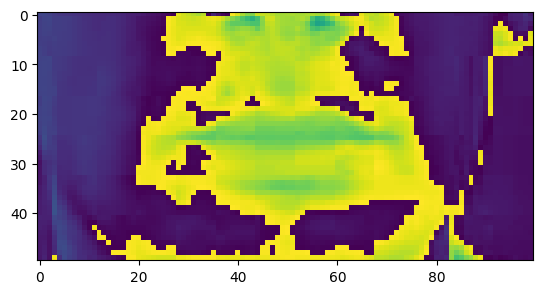

In [6]:
plt.imshow(load_video('.\\data\\s1\\bbal6n.mpg')[0].numpy())

In [7]:
load_alignments('.\\data\\alignments\\s1\\bbal6n.align')

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

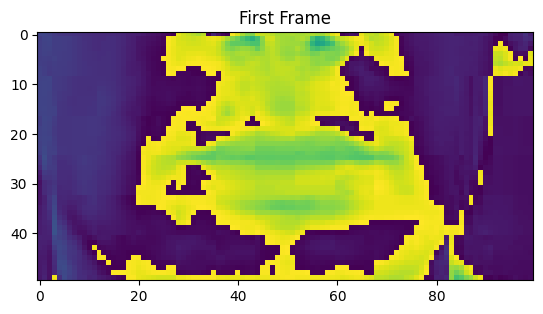

No of frames: 75


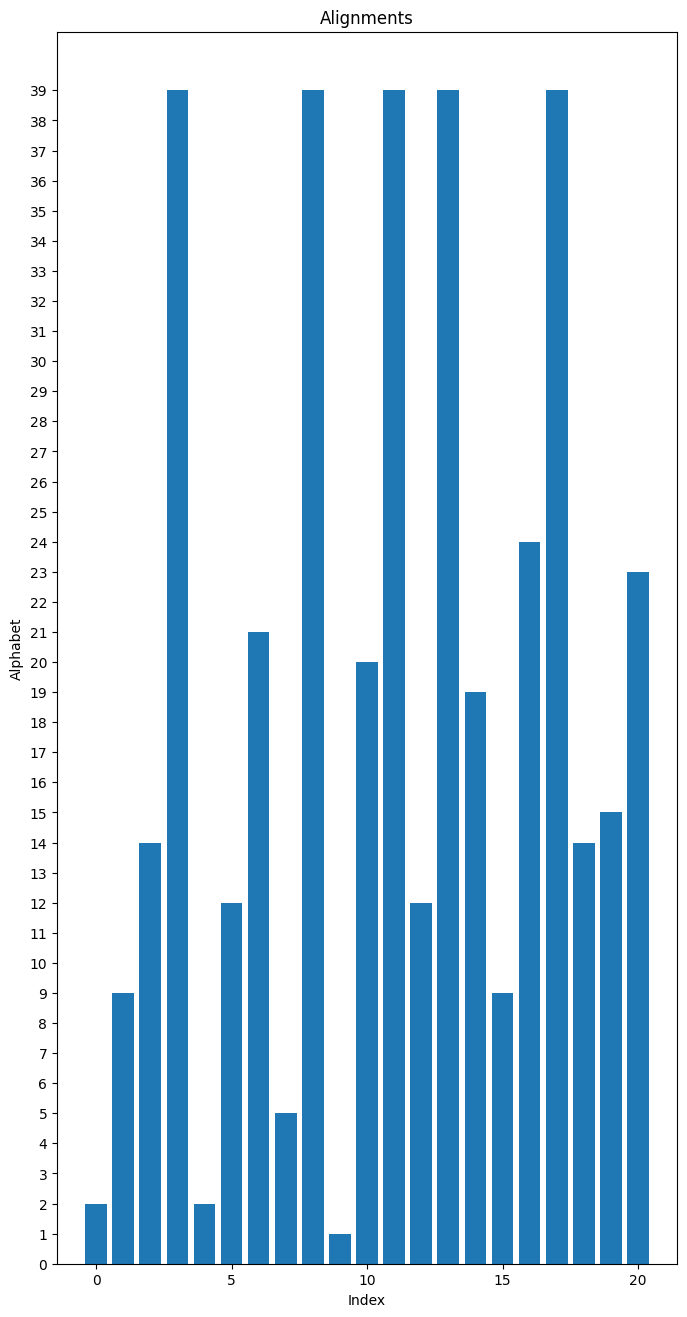

In [8]:
frames, alignments = load_data(tf.convert_to_tensor('.\\data\\alignments\\s1\\bbal6n.align'))

plt.title('First Frame')
plt.imshow(frames[0])
plt.show()

print(f'No of frames: { len(frames) }')

plt.figure(figsize = (8, 16))
plt.title('Alignments')
plt.bar(x = range(len(alignments.numpy())), height = alignments.numpy())
plt.ylabel('Alphabet')
plt.yticks(range(np.max(alignments.numpy()) + 1))
plt.xlabel('Index')
plt.show()

# Pipelining

In [ ]:
data = create_pipeline()
data


In [6]:
test_data = create_pipeline()

In [7]:
test_iter = test_data.as_numpy_iterator()

In [8]:
val = test_iter.next()
val[0]

array([[[[[ 1.8953712 ],
          [ 1.8953712 ],
          [ 1.8953712 ],
          ...,
          [ 0.1184607 ],
          [ 0.7107642 ],
          [ 0.789738  ]],

         [[ 1.8163974 ],
          [ 1.9348582 ],
          [ 2.0138319 ],
          ...,
          [10.0691595 ],
          [ 0.394869  ],
          [ 0.7502511 ]],

         [[ 1.8163974 ],
          [ 1.9348582 ],
          [ 1.9743451 ],
          ...,
          [ 9.674291  ],
          [ 9.950699  ],
          [ 0.0789738 ]],

         ...,

         [[ 0.9476856 ],
          [ 1.0266594 ],
          [ 0.9476856 ],
          ...,
          [10.029673  ],
          [ 0.0789738 ],
          [ 0.1579476 ]],

         [[ 0.98717254],
          [ 1.0661464 ],
          [ 0.9476856 ],
          ...,
          [ 9.792751  ],
          [ 0.0789738 ],
          [ 0.2764083 ]],

         [[ 0.789738  ],
          [ 0.5923035 ],
          [ 0.8687118 ],
          ...,
          [ 8.687119  ],
          [ 9.476856  ],
          

In [9]:
val[0][1]

array([[[[1.8588706 ],
         [1.8588706 ],
         [1.7873757 ],
         ...,
         [0.39322263],
         [0.3217276 ],
         [0.39322263]],

        [[1.8588706 ],
         [1.8588706 ],
         [1.8588706 ],
         ...,
         [9.044121  ],
         [9.044121  ],
         [0.14299005]],

        [[1.8588706 ],
         [1.8588706 ],
         [1.8588706 ],
         ...,
         [0.21448508],
         [0.25023258],
         [0.46471766]],

        ...,

        [[8.722393  ],
         [7.935948  ],
         [8.007442  ],
         ...,
         [8.32917   ],
         [9.115616  ],
         [0.5719602 ]],

        [[8.32917   ],
         [7.5069776 ],
         [7.5784726 ],
         ...,
         [8.257675  ],
         [9.008373  ],
         [0.46471766]],

        [[8.114685  ],
         [7.2924924 ],
         [7.3639874 ],
         ...,
         [8.221928  ],
         [8.901131  ],
         [0.2859801 ]]],


       [[[1.7873757 ],
         [1.8588706 ],
         [1.75

In [10]:
animation_frames = val[0][1]

# Convert float32 to uint8 and scale pixel values to [0, 255]
scaled_frames = (255 * (animation_frames - animation_frames.min()) / (animation_frames.max() - animation_frames.min())).astype(np.uint8)

reshaped_frames = np.squeeze(scaled_frames, axis=-1)

imageio.mimsave("./gifs/animation.gif", reshaped_frames, duration = 100)

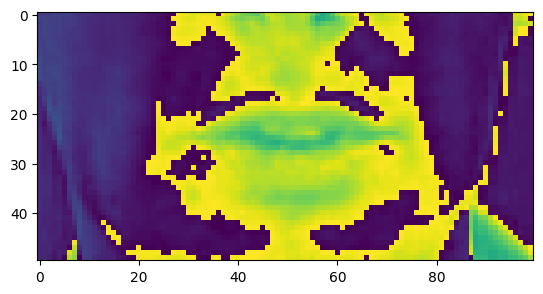

In [11]:
plt.imshow(val[0][0][32])
plt.show()

In [12]:
val[0][1].shape

(75, 50, 100, 1)

In [ ]:
train = data.take(300)
test = data.take(100)

# Modeling

In [14]:
yhat = LipNet(41).predict(val[0])
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

1/1 [==============================] - 5s 5s/step


<tf.Tensor: shape=(), dtype=string, numpy=b'qqqsssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss'>

In [8]:
loss = CTCLoss()
callbacks = [tf.keras.callbacks.ModelCheckpoint(os.path.join('model','checkpoint'),
                                                monitor='loss',
                                                save_weights_only=True),
             ProduceExample(test)
            ]
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)

In [9]:
model = LipNet(char_to_num.vocabulary_size() + 1)

In [10]:
model.compile(loss = loss, optimizer = optimizer)

In [11]:
print('Hi')

Hi


In [ ]:
model.fit(train, epochs = 1, callbacks = [callbacks])

 11/500 [..............................] - ETA: 32:07 - loss: 140.3020